In [1]:
%load_ext autoreload
%autoreload 2

import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
# print(physical_devices)
assert len(physical_devices) == 1, "Did not see the expected number of GPUs"
# to allow other tensorflow processes to use the gpu
# https://stackoverflow.com/a/60699372/7989988
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import numpy as np
from tensorflow import keras
from tensorflow.keras import Model, Input, layers
from IPython.display import display
import tensorflow_datasets as tfds
import time
import matplotlib.pyplot as plt
import enlighten
import tensorflow_probability as tfp
# from dotmap import DotMap
from box import Box as DotMap

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
tf.constant([1., 2, 3]) < 3

<tf.Tensor: shape=(3,), dtype=bool, numpy=array([ True,  True, False])>

In [3]:
import models
import training
import datasets
import vizualization
import schedules
import create_dataset

# todo
# - combine shuffled and unshuffled datasets into same thing
# - add extra shuffled indices and noise
# - add "noise fraction" parameter which can be changed the same way as the "n" parameter.
# - add different amounts of noise to the data and see what happens

In [4]:
config = DotMap({
    'ds': 'hands',
    'distributed': False,
    'minibatch_size': 8,
    'n_steps': 50000,
    'test_size': 300,
    'test_minibatch_size': 25,
    'test_interval': 500,
    'test_n_shuf': [392, 1, 64, 128, 256],
    'test_n_seq': [392, 1, 128, 256, 512],
    'test_autoregressive': False,
    'display_images': True,
    'display_image_interval': 500,
    'dont_display_until_loss': 0.48,
    'bg_color': [1.0, 0.4, 0.6],
    'lr_schedule': ['constant', 0.0004],
    'lr_warmup': 100,
    'grad_accum_steps': None, #['exponential', 1, 4],
    'max_accum_steps': 4,
    'use_wandb': False,
    'wandb_log_interval': 10,
    'loss_window_size': 80,
    'kmeans_batch_size': 1000,
    'mixed_float': False,
})

# need to change for multiworkerstrategy
if config.distributed:
    config.num_devices = len(physical_devices)
else:
    config.num_devices = 1
config.global_batch_size = config.minibatch_size * config.num_devices

In [18]:
# idea is to not have to re-run this cell for subsequent training runs unless the centroids change

ds_configs = DotMap({
    'mnist': {
        'type': 'image',
        'tfds_name': 'mnist',
        'continuous': False,
        'buffer_size': 60000,
        'noise_fraction': None,
        'shuffle': True,
        'n_split_distribution': 'mnist_gamma',
        'n_colors': 4,
        'n_color_dims': 1,
        'image_size': (28, 28),
    },
    'mnist_7x7': {
        'type': 'image',
        'tfds_name': 'mnist',
        'continuous': False,
        'buffer_size': 60000,
        'noise_fraction': None,
        'shuffle': True,
        'n_split_distribution': 'mnist_7x7_gamma',
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_7x7_contin': {
        'type': 'image',
        'tfds_name': 'mnist',
        'continuous': True,
        'loss': 'gaussian',
        'n_dist_params': 2, # gaussian dist has 2 params
        'buffer_size': 60000,
        'noise_fraction': None,
        'shuffle': True,
        'n_split_distribution': None,
        'n_colors': 4,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'mnist_binary_7x7': {
        'type': 'image',
        'tfds_name': 'mnist',
        'continuous': False,
        'buffer_size': 60000,
        'noise_fraction': None,
        'shuffle': True,
        'n_split_distribution': 'mnist_7x7_gamma',
        'n_colors': 2,
        'n_color_dims': 1,
        'rescale': (7, 7),
    },
    'celeb': {
        'type': 'image',
        'tfds_name': 'celeb_a',
        'continuous': False,
        'buffer_size': 10000,
        'noise_fraction': None,
        'shuffle': True,
        'n_colors': 16,
        'n_split_distribution': 'mnist_gamma',
        'n_color_dims': 3,
        'image_size': (218, 178),
        'rescale': (32, 39),
    },
    'hands': {
        'type': 'hands',
        'continuous': True,
        'loss': 'gaussian',
        'n_dist_params': 2, # gaussian dist has 2 params
        'shuffle': 'joints',
        'n_dof': 23,
        'n_frames': 30,
        'n_split_distribution': None,
        'buffer_size': 10000,
        'noise_fraction': None,
    },
})

config.dataset = ds_configs[config.ds]
config.dataset.discrete = not config.dataset.continuous

if config.dataset.type == 'image':
    dataset, metadata = tfds.load(config.dataset.tfds_name, with_info=True, as_supervised=True)
    ds_train_original = dataset['train'].map(datasets.ignore_label)
    ds_test_original = dataset['test'].map(datasets.ignore_label)
    centroids = datasets.find_centroids(config, ds_train_original)
    if config.dataset.rescale:
        config.dataset.image_size = config.dataset.rescale
    config.dataset.seq_length = config.dataset.image_size[0]*config.dataset.image_size[1]*config.dataset.n_color_dims
elif config.dataset.type == 'hands':
    dataset = create_dataset.tf_dataset(force=True)
    centroids = None
    # ignore left hands
    print(next(iter(dataset)))
    dataset = dataset.filter(datasets.is_right_hand)
    dataset = dataset.map(datasets.ignore_metadata)

    # TODO: split test and train
    ds_train_original = dataset
    ds_test_original = dataset

    config.dataset.seq_length = config.dataset.n_dof * config.dataset.n_frames
    
if config.dataset.n_split_distribution == 'mnist_gamma':
    gamma_dist, gamma_name = datasets.mnist_gamma_distribution()
    datasets.plot_distribution(config, gamma_dist, gamma_name)
elif config.dataset.n_split_distribution == 'mnist_7x7_gamma':
    gamma_dist, gamma_name = datasets.gamma_distribution_7x7()
    datasets.plot_distribution(config, gamma_dist, gamma_name)
elif config.dataset.n_split_distribution == 'mnist_12x12_gamma':
    gamma_dist, gamma_name = datasets.gamma_distribution_12x12()
    datasets.plot_distribution(config, gamma_dist, gamma_name)
else:
    gamma_dist, gamma_name = None, None


ds = datasets.Datasets(config, ds_train_original, ds_test_original, centroids, gamma_dist)
viz = vizualization.Viz(config, ds, centroids)
ds_train, ds_test = ds.make_datasets()


Forcing generation of a fresh dataset to "./cached_dataset/" ...


ic| datasets.py:324 in make_datasets() at 10:12:47.686
ic| datasets.py:346 in make_datasets() at 10:12:47.744


(<tf.Tensor: shape=(), dtype=string, numpy=b'manipnet/Data/SimpleVisualizer/Assets/BVH/wineglass3_2/rightHand.bvh'>, <tf.Tensor: shape=(), dtype=int32, numpy=8000>, <tf.Tensor: shape=(8000, 23), dtype=float32, numpy=
array([[-153.593   ,   13.43651 ,  -42.00934 , ...,  167.1838  ,
         -30.63354 ,   52.14901 ],
       [-153.6917  ,   13.69398 ,  -41.72995 , ...,  167.0725  ,
         -29.95093 ,   53.39282 ],
       [-153.6931  ,   13.86723 ,  -41.52698 , ...,  167.0263  ,
         -29.72571 ,   54.29317 ],
       ...,
       [ -76.4584  ,  -78.03699 ,  -51.57129 , ...,  150.5776  ,
          -2.118958,   12.46723 ],
       [ -75.01645 ,  -78.0997  ,  -53.06293 , ...,  150.7132  ,
          -2.264648,   12.90956 ],
       [ -73.41113 ,  -78.03735 ,  -54.68829 , ...,  150.9352  ,
          -2.807251,   12.95555 ]], dtype=float32)>, <tf.Tensor: shape=(), dtype=bool, numpy=True>)
Not using gradient accumulation


In [19]:
if config.dataset.type == 'image':
    display_colors, display_idxs, *_ = next(iter(ds_train))
    if config.grad_accum_steps:
        display_colors,display_idxs = display_colors[0],display_idxs[0]
    if config.dataset.continuous:
        display_colors = ds.reinvent_color_dim(display_colors)
    viz.showSeq(display_colors, display_idxs, config.dataset.image_size, do_unquantize=config.dataset.discrete, max_images=9)

In [20]:
if config.dataset.type == 'image':
    x_idx = tf.range(784)
    pos_enc = models.pos_enc(n_dims=16, scale=100)
    x = models.dual_positional_encoding((28,28), pos_enc)(x_idx)
    x = x / 2. + 0.5
    x = tf.expand_dims(tf.transpose(x), -1)
    x_idx = tf.tile(x_idx[None, :], [16, 1])
    viz.showSeq(x[:8], x_idx[:8], (28, 28), 8)
    viz.showSeq(x[8:16], x_idx[8:16], (28, 28), 8)
    viz.showSeq(x[16:24], x_idx[16:24], (28, 28), 8)
    viz.showSeq(x[24:], x_idx[24:], (28, 28), 8)

In [21]:


# model config
config.model = DotMap({
    'comment': '1layer',
    'discrete': config.dataset.discrete,
    'continuous': config.dataset.continuous,
    'n_enc_a_layers': 1,
    'n_enc_b_layers': 0,
    'ffl_dim': 64,
    'embd_dim': 64,
    'n_dec_layers': 1,
    'dec_dim': 400,
    'n_heads': 8,
    'dropout_rate': 0.1,
    'use_idxs_input': True,
    'architecture': 'gpt',
    'use_relative_positions': False,
    'activation': 'swish'
})

if config.model.continuous:
    config.model.distribution = config.dataset.loss
    config.model.n_dist_params = config.dataset.n_dist_params

if config.dataset.type == 'image':
    config.model.n_colors = config.dataset.n_colors
    config.model.n_color_dims = config.dataset.n_color_dims
    config.model.image_size = config.dataset.image_size
    config.model.seq_len = config.dataset.image_size[0] * config.dataset.image_size[1]
    config.model.position_embedding = 'pos_enc'
else:
    config.model.seq_len = config.dataset.n_frames * config.dataset.n_dof
    config.model.n_frames = config.dataset.n_frames
    config.model.n_dof = config.dataset.n_dof
    config.model.position_embedding = 'pos_and_embd'
    config.model.loc_scale = False
    config.model.scalar = True
    

if config.distributed == False:
    strategy = tf.distribute.get_strategy()
else:
    strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = models.transformer(config.model)
    # Adam params taken from the linked notebook
    optimizer = keras.optimizers.Adam(learning_rate=schedules.learning_rate_schedule(config))

if config.distributed:
    ds_train = strategy.experimental_distribute_dataset(ds_train)

config.training_mode = 'query_next'

import socket
model_name = models.model_name(config)
print(model_name)
# model.summary()

cuda10-hands-gpt-1layer-contin-bs1x1x8


In [22]:
filename = "/local/scratch/maxeonyx/msc-cgt-hands/manipnet/Data/SimpleVisualizer/Assets/BVH/bottle1_body1/rightHand.bvh"

dof = 23

def generate_data(conditioning_data, window_frames, new_frames):
    manager = enlighten.get_manager()
    
    # model = tf.keras.models.load_model(
    #     "/home/maxeonyx/msc/msc-cgt-hands/models/maxpc-hands-2layers-contin-bs1x1x8-righthand2",
    #     custom_objects={
    #         'negloglik': training.negloglik,
    #         'von_mises_loss': training.von_mises_loss
    #     },
    # )

    conditioning_data = tf.cast(conditioning_data, tf.float32)

    prev_frames = min(window_frames, conditioning_data.shape[0])
    n_frames_to_predict = new_frames

    counter = manager.counter(total=n_frames_to_predict*dof)
    # wm.progress_begin(0, n_frames_to_predict*dof)

    dof_idxs = tf.tile(tf.range(dof)[None, :], [prev_frames + 1, 1])
    frame_idxs = tf.tile(tf.range(prev_frames + 1)[:, None], [1, dof]) * dof
    idxs = dof_idxs + frame_idxs
    idxs = tf.reshape(idxs, [-1])

    def iteration(i, data):
        tar_idx = prev_frames*dof + i + 1
        inp_idxs = tf.range(i, prev_frames*dof + i)
        inp = data[-prev_frames*dof:]
        inp_len = tf.shape(inp_idxs)[0]
        tar_len = 1
        pred_params = model({
            "colors": inp[None, :],
            "inp_idxs": inp_idxs[None, :],
            "tar_idxs": tar_idx[None, None],
            "enc_mask": tf.zeros((inp_len, inp_len)),
            "dec_mask": tf.zeros((tar_len, inp_len)),
        })

        loc = pred_params[:, :, 0]
        # concentration = pred_params[:, :, 1]

        # dist = tfp.distributions.VonMises(loc=loc, concentration=concentration)
        # sample = dist.mean()
        sample = loc
        sample = tf.reshape(sample, [-1])
        data = tf.concat([data, sample], axis=0)
        return i+1, data

    @tf.function(
        input_signature=[tf.TensorSpec([None, dof])],
    )
    def do_batch(data):
        inp_data = tf.reshape(data[-prev_frames:, :], [prev_frames*dof])
        _i, out_data = tf.while_loop(
            cond=lambda i, data: i < dof,
            body=iteration,
            loop_vars=[
                tf.constant(0),
                inp_data
            ],
            shape_invariants=[
                tf.TensorShape([]),
                tf.TensorShape([None]),
            ],
        )
        return tf.reshape(out_data[-dof:], [1, dof])

#    test_data = tf.cast(create_dataset.load_one_bvh_file(filename, convert_deg_to_rad=True), tf.float32)
    generated_data = conditioning_data[:prev_frames, :]
    for i in range(n_frames_to_predict):
        result = do_batch(generated_data)
        generated_data = tf.concat([generated_data, result], axis=0)
        counter.update(incr=dof)
        # wm.progress_update(i*dof)
    counter.close()

    return generated_data

test_data = tf.cast(create_dataset.load_one_bvh_file(filename, convert_deg_to_rad=True), tf.float32)




   6/1000 [..............................] - ETA: 1:07 - loss: 8.3610e-05WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0334s vs `on_train_batch_end` time: 0.0335s). Check your callbacks.


1000/1000 [==============================] - ETA: 0s - loss: 7.4500e-05

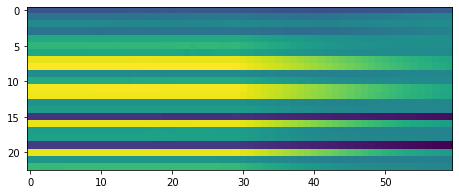

1000/1000 [==============================] - 70s 69ms/step - loss: 7.4500e-05


In [28]:
def gen_fig():
    generated_data = generate_data(test_data, 30, 30)
    _fig, ax = plt.subplots(figsize=(10, 3))
    ax.imshow(tf.transpose(generated_data))
    plt.show()

class PlotCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gen_fig()
        
# model.compile(loss=training.von_mises_loss, optimizer=optimizer)
model.compile(loss='mse', optimizer=optimizer)
ds_train_keras_fit = ds_train.map(training.ds_input_to_keras(config))
model.fit(ds_train_keras_fit, steps_per_epoch=1000, epochs=1, callbacks=[PlotCallback()])

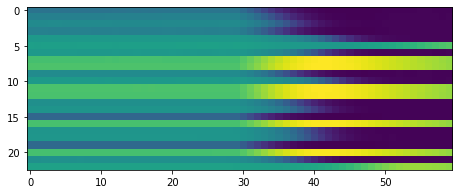

In [24]:
gen_fig()

In [29]:

model.save(f"models/{model_name}-may26-2")

INFO:tensorflow:Assets written to: models/cuda10-hands-gpt-1layer-contin-bs1x1x8-may26-2/assets


INFO:tensorflow:Assets written to: models/cuda10-hands-gpt-1layer-contin-bs1x1x8-may26-2/assets


#### 